# Lab 03: Text Classification on the DBpedia14 dataset

### Objectives:
1. Build a Naive Bayes classification model from scratch
2. Evaluate the performance of your model on the DBpedia14 dataset
3. Train an off-the-shelf NB classifier and compare its performance to your implementation
4. Train off-the-shelf implementations of the linear-SVM, RBF-kernel-SVM, and perceptron and compare their performance with the NB models

### Suggested Reading

1. https://arxiv.org/pdf/1811.12808.pdf

### Download the dataset

In [1]:
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split

# select part of the data 
M = 2400
df = datasets.load_dataset('dbpedia_14', split=['train[:100%]', 'test[100%:]'])[0].to_pandas().sample(frac=1).reset_index(drop=True)[:M]
# split the data into two sets 
df_train, df_test = train_test_split(df, test_size=0.2, random_state=777)

Reusing dataset dbpedia_14 (C:\Users\little page\.cache\huggingface\datasets\dbpedia_14\dbpedia_14\2.0.0\01dab9e10d969eadcdbc918be5a09c9190a24caeae33b10eee8f367a1e3f1f0c)


  0%|          | 0/2 [00:00<?, ?it/s]

# Part I: Build your own Naive Bayes classification model

### (10 pts) Task I: Build a model from scratch
Using your notes from lecture-02, implement a Naive Bayes model and train it on the DBpedia dataset. Also, feel free to use any text preprocessing you wish, such as the pipeline from Lab02. 

Below is a template class to help you think about the structure of this problem (feel free to design your own code if you like). It contains methods for each inference step in NB. It also has a classmethod that you could use to instantiate the class from a list of documents and a corresponding list of labels. Here we are suggesting you create a dictionary that maps each word to a unique $ith$ index in the $\phi_{i,k}$ probabilty matrix, which you need to estimate. Because the labels are a set of 0-indexed integers, they naturally map to a unique position $\mu_{k}$ (you should check this to make sure).

Define a preprocessing function that clean the data

In [2]:
import re
from spacy.language import Language
import spacy

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "numbr"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "),   # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

@Language.component("ng20")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)

pipeline.add_pipe("ng20");

In [3]:
## transfer to list 
df_train_list = list(df_train['content'])
df_test_list = list(df_test['content'])
## clean the data
for repl in replace:
    df_train_list = [re.sub(repl[0], repl[1], text) for text in df_train_list]
    df_test_list = [re.sub(repl[0], repl[1], text) for text in df_test_list]
## use pipeline to clean the data
df_train_cleaned = [pipeline(doc) for doc in df_train_list[:]]
df_test_cleaned = [pipeline(doc) for doc in df_test_list[:]]

df_train['content_cleaned'] = df_train_cleaned
df_test['content_cleaned'] = df_test_cleaned

## reset the index 
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

# concat two sets into one 
df_train_test = pd.concat([df_train,df_test],axis = 0, ignore_index = True)
df_train_test.head(2)

,label,title,content,content_cleaned
0,7,Minam Lake,Minam Lake is a high-elevation reservoir in t...,minam lake high elevation reservoir eagle cap ...
1,12,Student No.1,Student No.1 is a Telugu movie starring Jr NT...,student numbr telugu movie star jr ntr gajala ...


#### Build Naive Bayes classification model

In [4]:
## Construct Vocab
# put words from both sets into featurizer
featurizer = {word: idx for idx, word in enumerate(set(" ".join(list(df_train_test['content_cleaned'])).split(" ")))}

In [5]:
from typing import Union, List
import numpy as np


class NaiveBayesModel():
    
    def __init__(self):
        
        ## set globe variable
        self.M = 0 
        self.N = 0
        self.K = 0
        self.Xtr = 0
        self.phi_hat = 0
        self.mu_hat = 0
        
    def from_preprocessed_data(self,X,y):
        """
         Construct BOW features
         
         Parameters
        ----------
        X: the features in df_train, a list
        y: the categories in df_train, a list
        
        """
        #for the training dataset
        self.Xtr = np.zeros(shape=(len(X), len(featurizer)))
        for i, doc in enumerate(X):
            for word in doc.split(" "):
                j = featurizer[word]
                self.Xtr[i, j] += 1
                
        self.M = len(X)
        self.N = len(featurizer)
        self.K = len(set(np.array(y)))
    
    def estimate_mu(self,y):
        """
        Estimate P(Y), the prior over labels/prior probability 
        
        Parameters
        ----------
        y: the categories in df_train, a list
        
        """
        self.mu_hat = np.array([sum(np.array(y) == idx) / self.M for idx in range(self.K)])
        
    
    def estimate_phi(self,y):
        """
        Estimate phi, the N x K matrix 
        describing the probability of
        the nth word in the kth class./conditional probability 
        
        Parameters
        ----------
        y: the categories in df_train, a list
        
        """
        word_count_by_class = {k: np.sum(self.Xtr[np.where(np.array(y) == k)]) for k in range(self.K)}
        # Smoothing constant alpha
        alpha = 1.0
        self.phi_hat = np.zeros(shape=(self.K, self.N))
        for word, j in featurizer.items():
            for k in range(self.K):
                num_word_j_class_k = sum(np.squeeze(self.Xtr[np.where(np.array(y) == k), j]))
                self.phi_hat[k, j] = (alpha + num_word_j_class_k) / (alpha * self.N + word_count_by_class[k])

        # Each row of phi must sum to 1.0
        assert np.isclose(np.sum(self.phi_hat, axis=1), 1.0, atol=1e-6).all()
    
    def predict_label(self,X):
        """
        Compute label given some input text
        
        Parameters
        ----------
        text: raw input text
        X: the features in df_test, a list
        
        Returns
        -------
        int: corresponding to the predicted probablity
        """
        # for the testing dataset 
        Xte = np.zeros(shape=(len(X),len(featurizer)))
        for i, doc in enumerate(X):
            for word in doc.split(" "):
                j = featurizer[word]
                Xte[i,j] += 1
                           
        p_y_given_Xte = Xte.dot(np.log(self.phi_hat).T) + np.log(self.mu_hat)
       
        
        return p_y_given_Xte

In [6]:
if __name__ =='__main__':
    X = list(df_train['content_cleaned'])
    y = list(df_train['label'])
    X_test = list(df_test['content_cleaned'])
    
    NB = NaiveBayesModel()
    NB.from_preprocessed_data(X, y)
    NB.estimate_mu(y)
    NB.estimate_phi(y)
    yte_proba = NB.predict_label(X_test)
    ## predicte the category
    yte_hat = np.argmax(yte_proba,1)   

In [26]:
for i in range(yte_proba.shape[0]):
    logit = np.exp(yte_proba[i])
    prob = logit / np.sum(logit)
    yte_proba[i] = prob

In [27]:
print(yte_hat)

[ 7  1  3  1 11  0  6 13  5  8  9  4  8 10 10 13  1  9 10  0 10  3  4  5
 12  6  8  0 12 11 11  5  3  2 10  9  7  6  2 10  7  3 10 10  1  9 11 10
  2  5  8  7  6  7 11 10 10 10 11 10 10  6  9  3  6  6  0  4  9  7  8  5
 11 10  4 12  3  0  4  4  4  0 13  6  6  0  4 11  4  4  7 13  7  6 11 11
  8 13  7  7  6 11  1 12  4  0  2  4 12  1  2  3 13 11  6  2 12  9  7 13
  3  2 10  9 11  8  2 13  6  7  2  4  1  5 12  5  7  0  8 13  8  4 10  3
  8  3  6  3 12  0  3 12  8  4  4  5  9  1 10 11 11  9  5 13 13  5 10  1
  5 10  2  3 12 13 13  6 12 10  4  1 12  7  4 13  1  6  7  4  6 11  7 10
  9  0 11  6  7  6 12  0  8  4  4  4  5 13 10  6  9  6 13  0  7  7  0 13
  5 12  3  8  1  3  4 10  5 12 12  9 13  0 10  9  3  7  4  0  5  8  7  0
 13  6  2  4  1  1 11  8  7  6  8  7  6  2  6 12  5  1  5 10  0 12  9 13
 12 11  5  9  6 13  1  8 10  9 11 13  2  3  1  8  7  5  8  8 10 11 11  0
  1  2  9  3  7  2  4  4  1  9  8  7 11 10 12  3  5 13 12  9  6  3 13  4
  2  3  6 12  5  6  5  2  6 10  6  1 13  2  7  3 10

In [8]:
#X_test_array = np.array(df_test['content_cleaned'])
#y_train_array = np.array(df_train['label'])
#len(y_train_array)
## calculate the proba of the class
#Proba_score = np.zeros(shape=(len(X_test_array),14))
#for i in range(len(yte_proba)):
    #Proba_score[i] = (yte_proba[i]+ 0.01)/(sum(yte_proba[i])+ len(np.unique(y_train_array)/100))

# Part II: Model performance evaluation

Evaluating the performance of a classification model may seem as simple as computing an accuracy, and in some cases that is sufficient, but in general accuracy is not a reliable metric by itself. Typically we need to evaluate our model using several different metrics. 

One common issue is class imbalance, which is when the label distribution in the data varies far from uniform. In this case a high accuracy can be misleading because low frequency labels don't contribute equally to the score. More generally, this is one of the biggest drawbacks of using MLE in NLP: models tend to be much less sensitive to low probability labels than to higher probabilty labels. Later in this class we will explore models that learn by predicting words given their context, can you think of reasons why this can be problematic? Hint: remember Zipf's law?

Another reason to use multiple evaluation methods is that it can help you better understand your data. Evaluating performance on individual classes often reveals problems with the data that would otherwise go unnoticed. For example, if you observe an abundance of misclassified data specific to only a few classes, chances are you have inconsistent labels for those classes in the training set. This is very common in 3rd party mechanical turk data, where quality can vary wildly.

In this lab we will use three metrics and one visualization tool:

1. [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)
2. [F1 score](https://en.wikipedia.org/wiki/F-score)
3. [AUC ROC score](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
4. [The confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

The [metrics module](https://scikit-learn.org/stable/modules/model_evaluation.html) within sklearn provides support for nearly any evaluation metric that you will need.

# Part III: Compare your performance to an off-the-shelf NB classifier
Open source implementations of your custom NB classifier from Part I already exist of course. One such implementation is [`sklearn.naive_bayes.MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) from the sklearn library. 

### (5 pts) Task II: NB model comparison
Train this model on the same data and compare its performance with your model using the metrics from part II.

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def Model_performance_evaluation(test_true, test_predict, test_proba):
    '''
    input as list 
    '''
    print('Accuracy score:', accuracy_score(test_true, test_predict))
    print('F1 score:', f1_score(test_true, test_predict, average='macro'))
    print('AUC ROC score:', roc_auc_score(test_true, test_proba, multi_class='ovo', average='macro'))
    print('Confusion Matrix:')
    # Plot confusion matrix in a beautiful manner
    cm = confusion_matrix(test_true, test_predict)

    fig = plt.figure(figsize=(11, 7))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); 
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)
    
    plt.title('Refined Confusion Matrix', fontsize=20)

    plt.show()

#### Off-the-shelf NB classifier

In [11]:
## vectorization 
vec = CountVectorizer()
# the word frequency matrix
X_train = vec.fit_transform(df_train['content_cleaned']) 
X_test = vec.transform(df_test['content_cleaned'])

## fit the off-the-shelf NB model 
mnb = MultinomialNB()
mnb.fit(X_train,df_train['label'])
## make prediction 
y_predict = mnb.predict(X_test)
y_predict_proba = mnb.predict_proba(X_test)

Accuracy score: 0.9125
F1 score: 0.9107569316604925
AUC ROC score: 0.9894358568261646
Confusion Matrix:


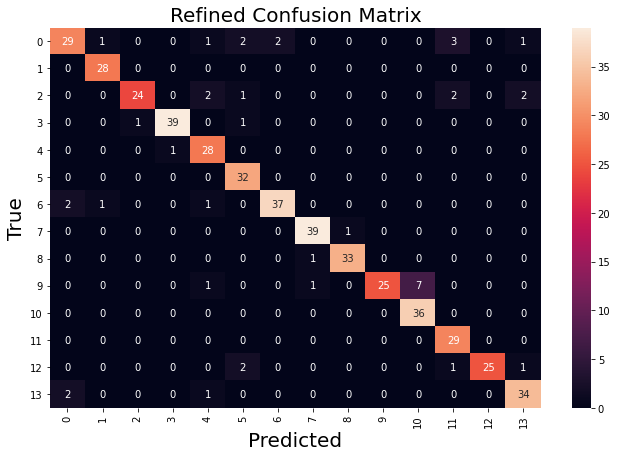

In [12]:
Model_performance_evaluation(list(df_test['label']), list(y_predict), list(y_predict_proba))

Accuracy score: 0.9083333333333333
F1 score: 0.9062913074595292
AUC ROC score: 0.9898088390202672
Confusion Matrix:


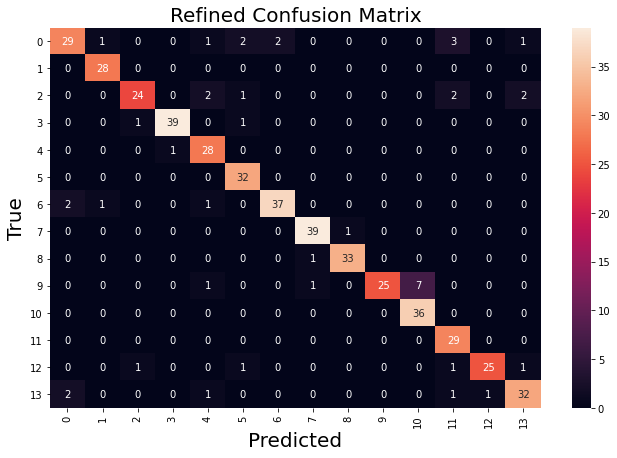

In [25]:
# transfer to list
y_test = list(df_test['label'])
y_test_hat= list(yte_hat)

Model_performance_evaluation(y_test, y_test_hat,list(yte_proba))

# Part IV: Compare NB to other classification models

Now that we've built and validated our NB classifier, we want to evaluate other models on this task.

### (5 pts) Task III: Evaluate the perceptron, SVM (linear), and SVM (RBF kernel)
Train and evaluate the following models on this dataset, and compare them with the NB models.

1. [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)
2. [Linear-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
3. [RBF-Kernel-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [14]:
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC

Accuracy score: 0.9125
F1 score: 0.9126557934840023
AUC ROC score: 0.9855619091229638
Confusion Matrix:


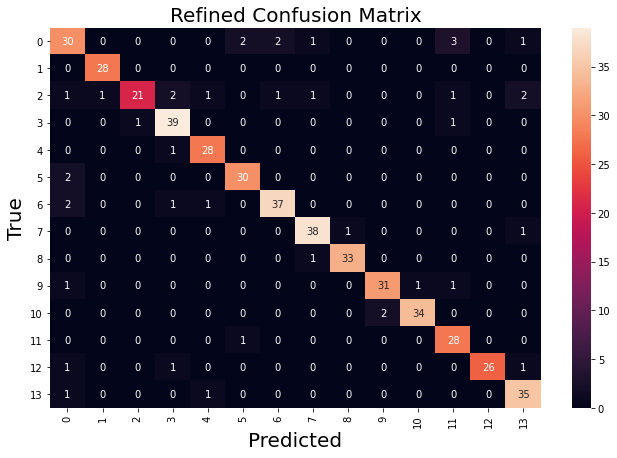

In [15]:
## Perceptron
Perceptron = Perceptron()
Perceptron.fit(X_train,df_train['label'])
Perceptron_pred = Perceptron.predict(X_test)
Perceptron_proba = Perceptron._predict_proba_lr(X_test)

# evaluate the performance
Model_performance_evaluation(list(df_test['label']), list(Perceptron_pred), list(Perceptron_proba))

Accuracy score: 0.91875
F1 score: 0.9184361159213367
AUC ROC score: 0.9879041240616464
Confusion Matrix:


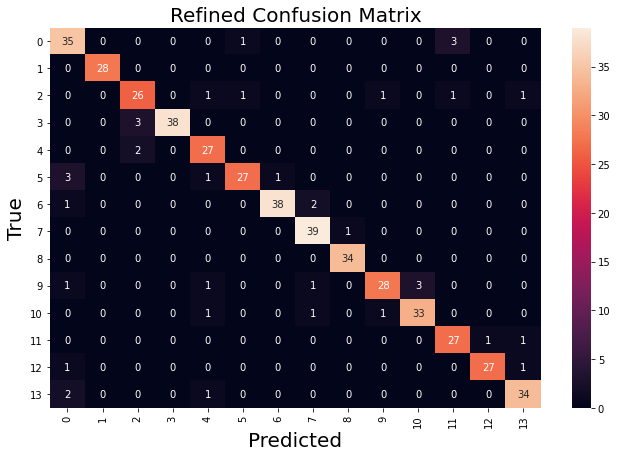

In [16]:
## Linear-SVM
Linear_SVM = LinearSVC()
Linear_SVM.fit(X_train,df_train['label'])
LinearSVC_pred = Linear_SVM.predict(X_test)
LinearSVC_prob = Linear_SVM._predict_proba_lr(X_test)

# evaluate the performance
Model_performance_evaluation(list(df_test['label']), list(LinearSVC_pred), list(LinearSVC_prob))

Accuracy score: 0.85
F1 score: 0.8538211149266081
AUC ROC score: 0.9853916885907958
Confusion Matrix:


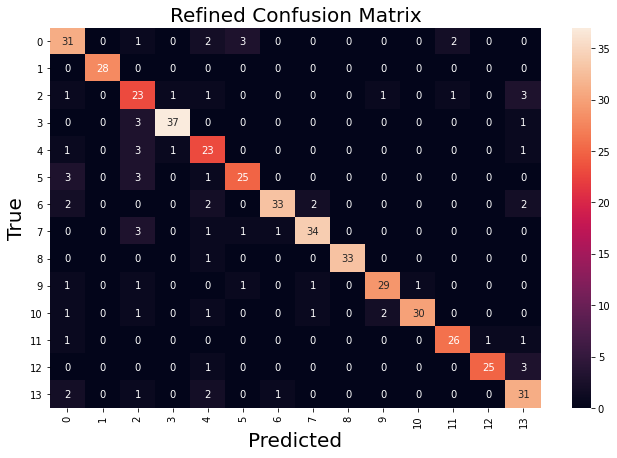

In [17]:
## RBF-Kernel-SVM
RBF_Kernel_SVM = SVC(probability=True)
RBF_Kernel_SVM.fit(X_train,df_train['label'])
RBF_Kernel_SVM_pred = RBF_Kernel_SVM.predict(X_test)
RBF_Kernel_SVM_prob = RBF_Kernel_SVM.predict_proba(X_test)

# evaluate the performance
Model_performance_evaluation(list(df_test['label']), list(RBF_Kernel_SVM_pred), list(RBF_Kernel_SVM_prob))

### (5 pts) Task IV: Select the best model

1. Which model performed the best overall? 
2. What metric(s) influence this decision?
3. Does the model that learns a non-linear decision boundary help?

Precision reflects the model's ability to distinguish negative samples, the higher the Precision, the stronger the model's ability to distinguish negative samples; Recall reflects the model's ability to identify positive samples, the higher the Recall, the stronger the model's ability to identify positive samples. F1 score is a combination of the two, the higher the F1 score, the more robust the model is.

1. With the Accuracy score of 0.9104167, F1 score of 0.90891, and AUC ROC score of 0.99066, Linear-SVM perform the best overall.
2. Accuracy and F1.
3. A non-linear decision boundary help little in this case.